In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim

from torchsummary import summary

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.family         : sans-serif        ')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


In [2]:
def seq_tar_gen(raw_data, tw=16, pw=1):
    """
    des:
        输入时间序列，构造用于监督学习的样本（[seq， tar]形式）
    para: 
        raw_data:
        tw:
        pw:
    return:
    """
    sample = []
    for i in range(len(raw_data) - tw):
        sample.append([raw_data[i:i + tw], raw_data[i + tw: i + tw + pw]])
    return sample

raw_data = np.array(range(10))
test_seq = seq_tar_gen(raw_data=raw_data, tw=6, pw=1)
for seq in test_seq:
    print(seq)

[array([0, 1, 2, 3, 4, 5]), array([6])]
[array([1, 2, 3, 4, 5, 6]), array([7])]
[array([2, 3, 4, 5, 6, 7]), array([8])]
[array([3, 4, 5, 6, 7, 8]), array([9])]


In [3]:
# Dataset
class CALCEBattery(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sample = self.data[index]
        seq = torch.FloatTensor(sample[0])
        tar = torch.FloatTensor(sample[1])
        return seq, tar
    
test_dataset = CALCEBattery(test_seq)
for i in test_dataset:
    print(i)

(tensor([0., 1., 2., 3., 4., 5.]), tensor([6.]))
(tensor([1., 2., 3., 4., 5., 6.]), tensor([7.]))
(tensor([2., 3., 4., 5., 6., 7.]), tensor([8.]))
(tensor([3., 4., 5., 6., 7., 8.]), tensor([9.]))


In [4]:
# 构造数据集
calce_data_path = "./data/calce/CALCE.npy"
calce_data = np.load(calce_data_path, allow_pickle=True).item()
battery_names = list(calce_data.keys())

window_size = 16
b35 = seq_tar_gen(calce_data[battery_names[0]]["capacity"].to_list(), window_size)
b36 = seq_tar_gen(calce_data[battery_names[1]]["capacity"].to_list(), window_size)
b37 = seq_tar_gen(calce_data[battery_names[2]]["capacity"].to_list(), window_size)
b38 = seq_tar_gen(calce_data[battery_names[3]]["capacity"].to_list(), window_size)

# b35 = CALCEBattery(b35)
# print(b35[0][0].shape, b35[0][1].shape) # torch.Size([16]) torch.Size([1])

In [9]:
# 定义多层感知机网络结构
class MLPNet(nn.Module):
    def __init__(self, n_features=16, n_outputs=1, hidden_layers=[16, 8, 4, 2]):
        super(MLPNet, self).__init__()
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden_layers = hidden_layers
        self.n_mlp_layers = len(hidden_layers)

        self.input2mlp = nn.Linear(self.n_features, self.hidden_layers[0])
        mlp = []
        for i in range(self.n_mlp_layers):
            if i == self.n_mlp_layers - 1:
                # mlp.append(nn.LeakyReLU())
                mlp.append(nn.Linear(self.hidden_layers[-1], n_outputs))
            else:
                # mlp.append(nn.LeakyReLU())
                mlp.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i + 1]))
        self.mlp = nn.Sequential(*mlp)

    def forward(self, x):
        input_size = x.size(0) # input_size 即 batch_size
        x = self.input2mlp(x)
        x = self.mlp(x)
        return x
    
model = MLPNet()
print(model)

MLPNet(
  (input2mlp): Linear(in_features=16, out_features=16, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [17]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

epochs = 20
lr = 1e-2
window_size = 16
# batch_size = 16

model = MLPNet(hidden_layers=[16]).to(device)
print(model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

using device: cuda
MLPNet(
  (input2mlp): Linear(in_features=16, out_features=16, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)


epoch 1, train loss 0.019253123642152384, validation loss 0.0015808169264346361
epoch 2, train loss 0.019907109843835417, validation loss 0.0004989549051970243
epoch 3, train loss 0.020223504950667524, validation loss 0.00043162776273675263
epoch 4, train loss 0.020555625439818766, validation loss 0.0004499350907281041
epoch 5, train loss 0.020862558836638023, validation loss 0.0004062239604536444
epoch 6, train loss 0.021160488663655188, validation loss 0.00042564282193779945
epoch 7, train loss 0.021481313640752987, validation loss 0.00038715885602869093
epoch 8, train loss 0.02177045259320746, validation loss 0.0003700879169628024
epoch 9, train loss 0.022087225328464733, validation loss 0.0004092216258868575
epoch 10, train loss 0.022364745914496276, validation loss 0.00034906648215837777
epoch 11, train loss 0.022644564168311062, validation loss 0.0003340077819302678
epoch 12, train loss 0.022952471141454427, validation loss 0.0003496396238915622
epoch 13, train loss 0.02326927451

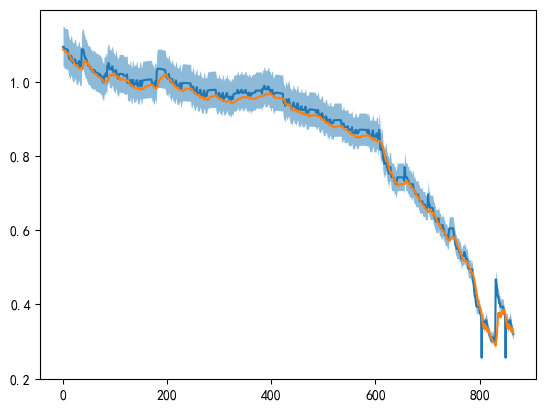

In [18]:
# b35为验证集
train_dataset = b36 + b37 + b38
test_dataset = b35
train_dataset = CALCEBattery(train_dataset)
test_dataset = CALCEBattery(test_dataset)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train_losses, val_losses = [], []

train_loss, val_loss = 0.0, 0.0
for epoch in range(epochs):
    model.train()
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

# 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

epoch 1, train loss 0.00030719305815099773, validation loss 0.00022539439669344574
epoch 2, train loss 0.0005667878532552674, validation loss 0.0003484968328848481
epoch 3, train loss 0.0008303835352307942, validation loss 0.0002648246008902788
epoch 4, train loss 0.0011169380990891527, validation loss 0.00023987519671209157
epoch 5, train loss 0.0013782373902854902, validation loss 0.0003294810885563493
epoch 6, train loss 0.0016544142432725164, validation loss 0.00034975327434949577
epoch 7, train loss 0.00187314153303801, validation loss 0.00022651265317108482
epoch 8, train loss 0.0020831958642950417, validation loss 0.00022208178415894508
epoch 9, train loss 0.0023341250911967522, validation loss 0.00032493731123395264
epoch 10, train loss 0.002574395564186654, validation loss 0.00022095211897976696
epoch 11, train loss 0.0027939407615866167, validation loss 0.0002026747533818707
epoch 12, train loss 0.0030299207760849226, validation loss 0.0002056002413155511
epoch 13, train loss

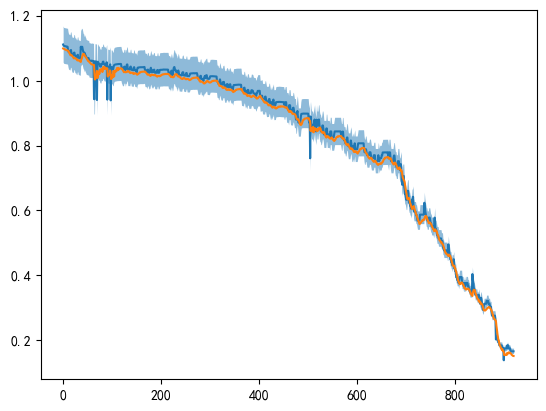

In [19]:
# b36为验证集
train_dataset = b35 + b37 + b38
test_dataset = b36
train_dataset = CALCEBattery(train_dataset)
test_dataset = CALCEBattery(test_dataset)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train_losses, val_losses = [], []

train_loss, val_loss = 0.0, 0.0
for epoch in range(epochs):
    model.train()
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

# 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

epoch 1, train loss 0.0002714808643581453, validation loss 0.00037133341538719833
epoch 2, train loss 0.0005017687626709578, validation loss 0.0001741171145113185
epoch 3, train loss 0.0007590349305246491, validation loss 0.00015802975394763052
epoch 4, train loss 0.000976958888023891, validation loss 0.00019235479703638703
epoch 5, train loss 0.0012063000694665946, validation loss 0.00016372585378121585
epoch 6, train loss 0.0014528719219788922, validation loss 0.00040337443351745605
epoch 7, train loss 0.0017435056396053192, validation loss 0.000162656040629372
epoch 8, train loss 0.0019855055355758942, validation loss 0.00018644686497282237
epoch 9, train loss 0.0022411753449061464, validation loss 0.00015219990746118128
epoch 10, train loss 0.002453490763452893, validation loss 0.00020145571033935994
epoch 11, train loss 0.0026645714660426373, validation loss 0.00015153018466662616
epoch 12, train loss 0.0029000679624214066, validation loss 0.00025738688418641686
epoch 13, train lo

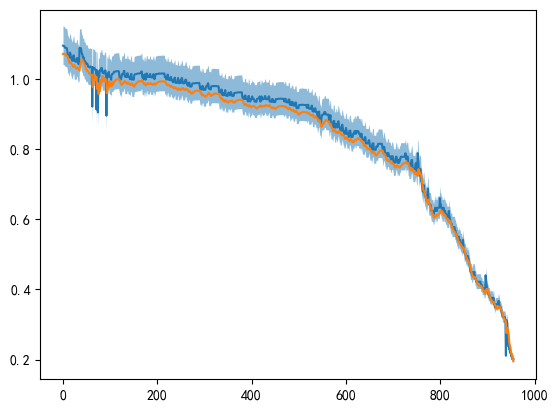

In [20]:
# b37为验证集
train_dataset = b35 + b36 + b38
test_dataset = b37
train_dataset = CALCEBattery(train_dataset)
test_dataset = CALCEBattery(test_dataset)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train_losses, val_losses = [], []

train_loss, val_loss = 0.0, 0.0
for epoch in range(epochs):
    model.train()
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

# 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

epoch 1, train loss 0.00023706363013885958, validation loss 0.0002458015806041658
epoch 2, train loss 0.0004582899098242579, validation loss 0.00019521063950378448
epoch 3, train loss 0.0006746293499820113, validation loss 0.00021803822892252356
epoch 4, train loss 0.000920966141229444, validation loss 0.0002878985833376646
epoch 5, train loss 0.0011575915578273558, validation loss 0.00023546037846244872
epoch 6, train loss 0.0013881089855922889, validation loss 0.00023996208619792014
epoch 7, train loss 0.0016127704059536606, validation loss 0.0001870903797680512
epoch 8, train loss 0.0017977367781916887, validation loss 0.00018120472668670118
epoch 9, train loss 0.0020138968371019323, validation loss 0.00024395111540798098
epoch 10, train loss 0.0022429130689023053, validation loss 0.0003389408811926842
epoch 11, train loss 0.0024500222394255064, validation loss 0.00031889151432551444
epoch 12, train loss 0.002645785639563042, validation loss 0.00020803787629120052
epoch 13, train lo

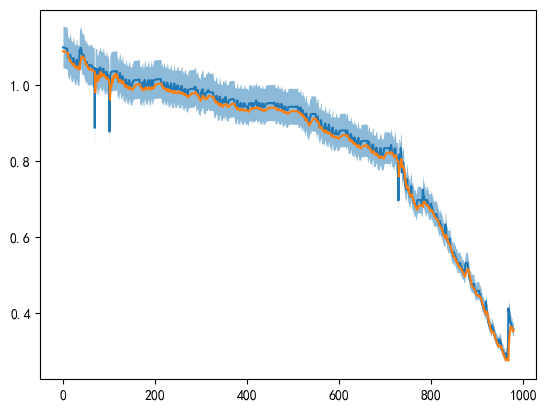

In [21]:
# b38为验证集
train_dataset = b35 + b36 + b37
test_dataset = b38
train_dataset = CALCEBattery(train_dataset)
test_dataset = CALCEBattery(test_dataset)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train_losses, val_losses = [], []

train_loss, val_loss = 0.0, 0.0
for epoch in range(epochs):
    model.train()
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

# 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)